# Get Affine Tranfrom
Need to get affine transformation form Realsense RGB Image to Ximea Image so we know where our eye positions are in ximea space. We'll do this per-task for now.

# NOTE: Did this for each head mounted trial separately, choosing a transform that worked well for each trial, adjusting the frame used for calibration, threshold for point distance, and gamma adjustment to frame until calibration was visually correct

In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

line_number=15

#paths for all the things
base_dir='/hmet_data'
data_dir = os.path.join(base_dir, 'raw')
png_dir = os.path.join(base_dir, 'pngs')
ana_dir = os.path.join(base_dir, 'analysis')
trace_dir = os.path.join(base_dir, 'traces')
trial_list_path = '~/st-bravo_analysis/trial_list.csv'
trial_line = pd.read_csv(trial_list_path).iloc[line_number]
data_folder = os.path.join(data_dir, trial_line['folder'], str(trial_line['trial']).zfill(3))
png_folder = os.path.join(png_dir, trial_line['task'], trial_line['subject'], str(trial_line['iter']))
ana_folder = os.path.join(ana_dir, trial_line['task'], trial_line['subject'], str(trial_line['iter']))

#ximea_path = '/hmet_data/pngs/phone/ag/1/'
#rsrgb_path = '/hmet_data/raw/2020_02_26/005/'
index_file = os.path.join(ana_folder,'common_timeline.csv')
ximea_idx_file = os.path.join(ana_folder,'common_timeline_ximea_sampleidx.csv')
rsrgb_idx_file = os.path.join(ana_folder,'common_timeline_rsrgb_sampleidx.csv')

#load index lists
ximea_idx =  np.loadtxt(ximea_idx_file, delimiter=',', skiprows=0)
rsrgb_idx =  np.loadtxt(rsrgb_idx_file, delimiter=',', skiprows=0)

#get index
#tidx = len(ximea_idx)//2 - 100
tidx=0
ximea_frame = int(ximea_idx[tidx])
rsrgb_frame = int(rsrgb_idx[tidx])
print(f'Ximea Frame: {ximea_frame}')
print(f'RSRGB Frame: {rsrgb_frame}')

#get frames
ximea_file = os.path.join(png_folder, f'frame_{ximea_frame}.png')
rsrgb_file = os.path.join(data_folder, f'world.mp4')
ximea_frame = cv2.imread(ximea_file)
#get rsrgb frame from movie
capture = cv2.VideoCapture(rsrgb_file)
capture.set(cv2.CAP_PROP_POS_FRAMES, rsrgb_frame)
print('Position:', int(capture.get(cv2.CAP_PROP_POS_FRAMES)))
_, rsrgb_frame = capture.read()
ximea_frame = cv2.cvtColor(ximea_frame, cv2.COLOR_BGR2RGB)
rsrgb_frame = cv2.cvtColor(rsrgb_frame, cv2.COLOR_BGR2RGB)

Ximea Frame: 6
RSRGB Frame: 0
Position: 0


## Upsample Realsense RGB Image

In [4]:
rsrgb_frame.shape

(480, 640, 3)

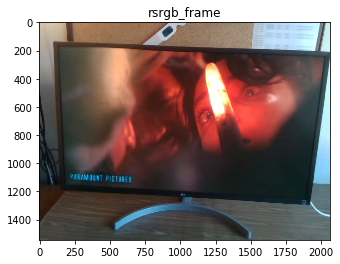

In [85]:
rsrgb_frame_adj = cv2.resize(rsrgb_frame, dsize=((np.shape(ximea_frame)[:2])[::-1]))
#rsrgb_frame_adj = np.mean(rsrgb_frame_adj,axis=-1)

plt.imshow(rsrgb_frame_adj)
plt.title('rsrgb_frame')
plt.show()

## Adjust Ximea Image Brightness

(1544, 2064, 3)


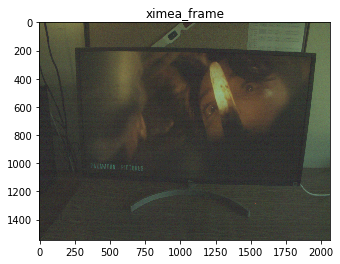

In [86]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    div = np.max(image).astype('float32')
    #div=255.0
    table = np.array([((i / div) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

ximea_frame_adj = ximea_frame.copy()
#ximea_frame_adj = np.mean(ximea_frame,axis=-1)
print(ximea_frame_adj.shape)
#adjust brightness of ximea so we can see something
#ximea_frame_adj = (ximea_frame_adj+1)/np.max(ximea_frame_adj)
#thresh = 75.
#ximea_frame_adj[ximea_frame_adj>thresh]= thresh
#ximea_frame_adj = ximea_frame_adj/thresh
#ximea_frame_adj = (ximea_frame_adj*255).astype('float32')
#ximea_frame_adj = ((ximea_frame_adj.astype(np.float32)/np.max(ximea_frame_adj)).astype('uint8'))*255

ximea_frame_adj = adjust_gamma(ximea_frame_adj, gamma=2)
#equ = cv2.equalizeHist(ximea_frame_adj)

#make sure frames make sense
plt.imshow(ximea_frame_adj)
plt.title('ximea_frame')
plt.show()

Text(0.5, 1.0, 'Luminance Distributions')

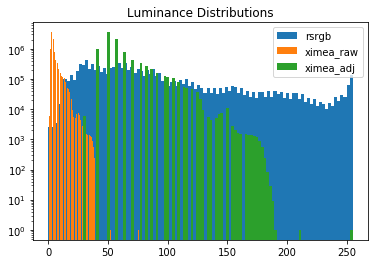

In [87]:
plt.hist(rsrgb_frame_adj.flatten(),bins=100,label='rsrgb');
plt.hist(ximea_frame.flatten(),bins=100,label='ximea_raw');
plt.hist(ximea_frame_adj.flatten(),bins=100,label='ximea_adj');
plt.yscale('log')
plt.legend()
plt.title('Luminance Distributions')

In [88]:
print(f'RSRGB shape: {np.shape(rsrgb_frame_adj)}')
print(f'Ximea shape: {np.shape(ximea_frame_adj)}')

RSRGB shape: (1544, 2064, 3)
Ximea shape: (1544, 2064, 3)


In [95]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(rsrgb_frame_adj,None)
kp2, des2 = sift.detectAndCompute(ximea_frame_adj,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 15) #5 default
search_params = dict(checks=1000)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.65*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [96]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2)
#G, mask = cv2.getAffineTransform(pts1,pts2)
H = cv2.findHomography(pts1, pts2)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]



(<matplotlib.axes._subplots.AxesSubplot at 0x7f34fe183450>,
 Text(0.5, 1.0, 'Ximea Frame'))

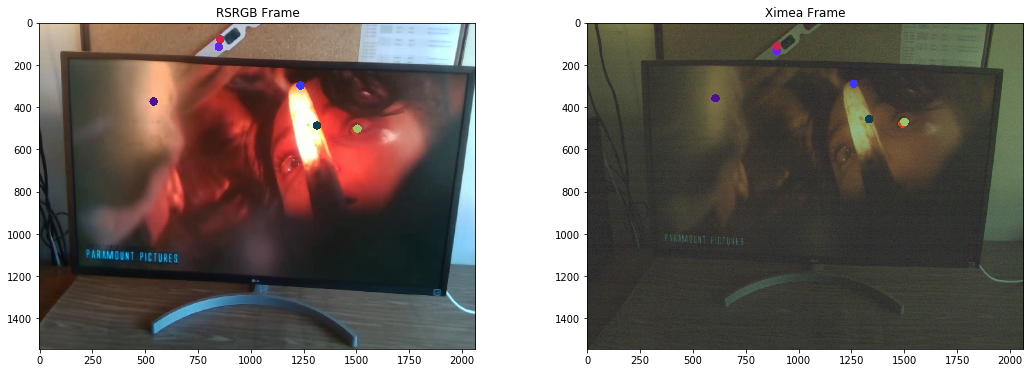

In [97]:
rsrgb_frame_points = rsrgb_frame_adj.copy()
ximea_frame_points = ximea_frame_adj.copy()

def drawpoints(img1,img2,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
    '''
    r,c,_ = img1.shape
    for pt1,pt2 in zip(pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        img1 = cv2.circle(img1,tuple(pt1),20,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),20,color,-1)
    return img1,img2


I really don't know whats going on here but it's not transforming the image so boo.

## Try Homography
hint.. this works!

[[ 1.02924026e+00  7.37279227e-03  6.41095265e+01]
 [ 1.84326042e-02  9.11242852e-01  2.11003294e+01]
 [ 6.00239140e-05 -2.53617381e-05  1.00000000e+00]]


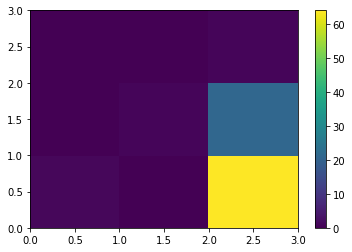

In [98]:
print(H[0])
plt.pcolormesh(H[0])
plt.colorbar()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f34f56c18d0>,
 Text(0.5, 1.0, 'Ximea Frame'))

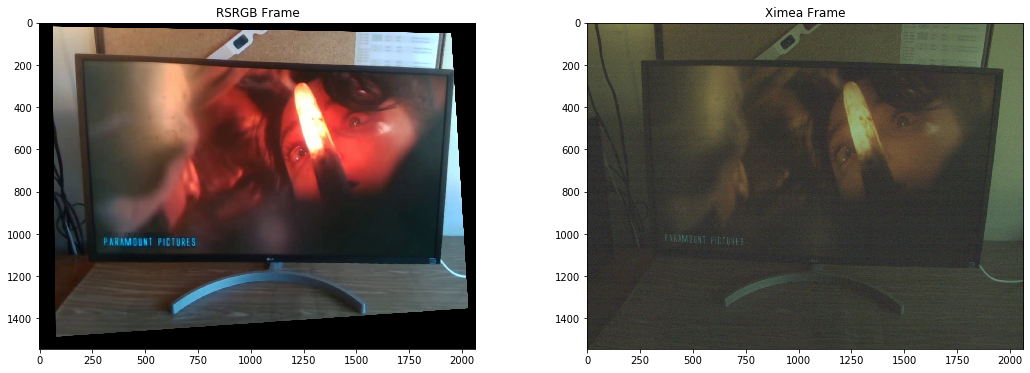

In [99]:
rsrgb_transformed = cv2.warpPerspective(rsrgb_frame_adj, H[0], np.shape(rsrgb_frame_adj)[:2][::-1])
plt.close()
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(rsrgb_transformed),plt.title('RSRGB Frame')
plt.subplot(122),plt.imshow(ximea_frame_adj),plt.title('Ximea Frame')


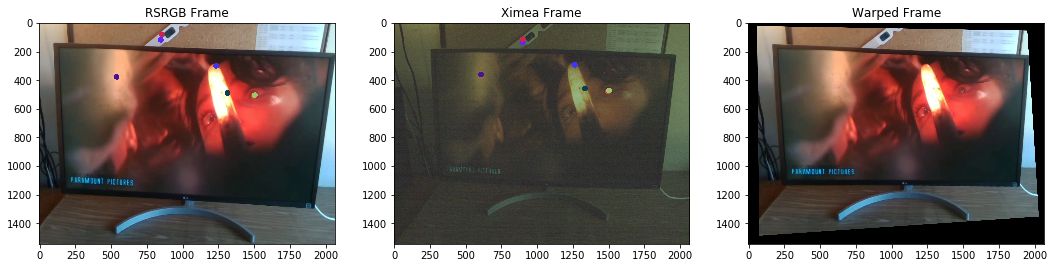

In [100]:
plt.figure(figsize=(18,6))
plt.subplot(131),plt.imshow(img5),plt.title('RSRGB Frame')
plt.subplot(132),plt.imshow(img6),plt.title('Ximea Frame')
plt.subplot(133),plt.imshow(rsrgb_transformed),plt.title('Warped Frame')
plt.savefig(os.path.join(ana_folder, 'rsrgbToXimPoints.png'))

In [101]:
H[0].shape

(3, 3)

Text(0.5, 1.0, 'Ximea Frame: point at 897.5, 475.6')

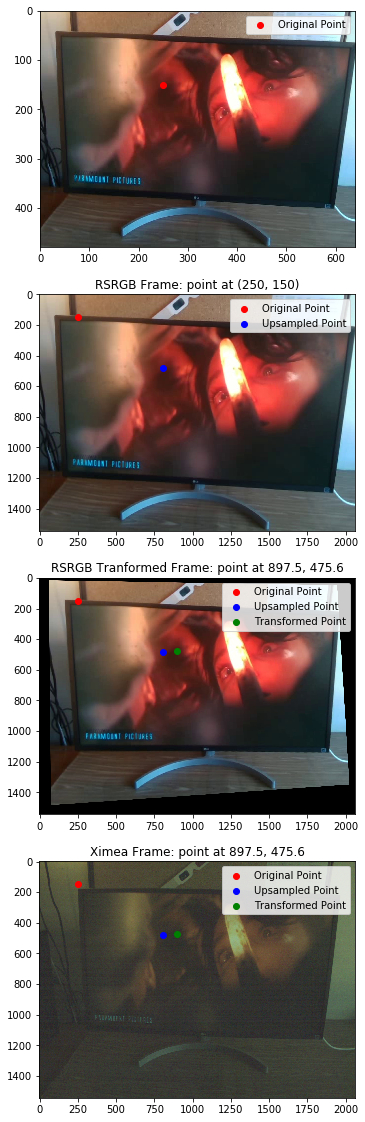

In [102]:
plt.close()
plt.figure(figsize=(8,20))
fix_x = 250
fix_y = 150

upsample_ratio_y = rsrgb_frame_adj.shape[0]/rsrgb_frame.shape[0]
upsample_ratio_x = rsrgb_frame_adj.shape[1]/rsrgb_frame.shape[1]

fix_x_up = fix_x * upsample_ratio_x
fix_y_up = fix_y * upsample_ratio_y

trans_fix_x, trans_fix_y, garbage = H[0]@(fix_x_up, fix_y_up, 1)

plt.subplot(411),plt.imshow(rsrgb_frame)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
#plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
#plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.subplot(412),plt.imshow(rsrgb_frame_adj)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
#plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'RSRGB Frame: point at {fix_x, fix_y}')
plt.subplot(413),plt.imshow(rsrgb_transformed)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'RSRGB Tranformed Frame: point at {trans_fix_x:.1f}, {trans_fix_y:.1f}')
plt.subplot(414),plt.imshow(ximea_frame_adj)
plt.scatter(fix_x, fix_y, color='r', label=('Original Point'))
plt.scatter(fix_x_up, fix_y_up, color='b', label=('Upsampled Point'))
plt.scatter(trans_fix_x, trans_fix_y, color='g', label=('Transformed Point'))
plt.legend()
plt.title(f'Ximea Frame: point at {trans_fix_x:.1f}, {trans_fix_y:.1f}')


## Apply Homogrophy to pupil positions and save

In [5]:
pupil_data_fname = os.path.join(ana_dir, 'calibrated_traces', f"fixation_point{trial_line['folder']}-{str(trial_line['trial']).zfill(3)}.txt")
pupil_idx_fname = os.path.join(ana_folder, 'common_timeline_pupil_sampleidx.csv')
pupil_samples = np.loadtxt(pupil_data_fname,delimiter=',')
pupil_samples_idx = np.loadtxt(pupil_idx_fname,delimiter=',').astype(int)
pupil_data = np.loadtxt(pupil_data_fname,delimiter=',')
pupil_data = pupil_data[:,[5,6]]
pup_pos = pupil_data.take(pupil_samples_idx,axis=0)

#get pupil positions
pos_x = pup_pos[:,0]
pos_y = pup_pos[:,1]

#calculate Upsample effect on and eye positions
upsample_ratio_y = rsrgb_frame_adj.shape[0]/rsrgb_frame.shape[0]
upsample_ratio_x = rsrgb_frame_adj.shape[1]/rsrgb_frame.shape[1]
pos_x_up = pos_x * upsample_ratio_x
pos_y_up = pos_y * upsample_ratio_y
positions_upsampled = pos_x_up, pos_y_up, np.repeat(1,len(pos_x_up))

#apply transform matrix to pupil positions
trans_pupil_pos = np.rint(H[0]@(positions_upsampled))

#take only first two cols (it was 1 padded), and put back in correcrt dims with transpose
pupil_positions = trans_pupil_pos[:2].T

#save!
pupil_positions_converted_file = os.path.join(ana_folder,'pupil_positions_ximea_space.npy')
np.save(pupil_positions_converted_file,pupil_positions)


OSError: /hmet_data/analysis/calibrated_traces/fixation_point2020_02_27-004.txt not found.

In [ ]:
pup_pos_loaded = np.load(pupil_positions_converted_file)
common_timeline = np.loadtxt(os.path.join(ana_folder, 'common_timeline.csv'),delimiter=',')
print(len(common_timeline), len(pup_pos_loaded))
assert(len(common_timeline) == len(pup_pos_loaded))


In [ ]:
#test loading NOTE THIS IS TRANSPOSED IN Y FROM IMSHOW
print(pupil_positions_converted_file)
plt.scatter(pup_pos_loaded[:,0], pup_pos_loaded[:,1])
#plt.scatter(pup_pos_old[:,0], pup_pos_old[:,1])

## Apply Fundamental Matrix

this doesn't work and i don't know why....

None


ValueError: not enough values to unpack (expected 2, got 0)

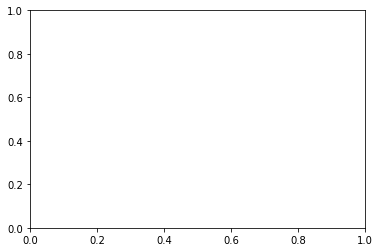

In [18]:
print(F)
plt.pcolormesh(F)
plt.colorbar()

rsrgb_transformed = cv2.transform(rsrgb_frame_adj, F, np.shape(rsrgb_frame_adj))
plt.figure(figsize=(18,6))
plt.subplot(121),plt.imshow(rsrgb_transformed),plt.title('RSRGB Frame')
plt.subplot(122),plt.imshow(ximea_frame_adj),plt.title('Ximea Frame')